In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_2048_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 2048)              1703936   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 1)                 129       


Total params: 4491265 (17.13 MB)


Trainable params: 4491265 (17.13 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:26 - loss: 0.0531 - STD: 3.3836e-05 - MAE: 0.2223

 3/64 [>.............................] - ETA: 1s - loss: 0.0297 - STD: 5.2692e-05 - MAE: 0.1292  

 5/64 [=>............................] - ETA: 1s - loss: 0.0290 - STD: 3.7957e-05 - MAE: 0.1275

 7/64 [==>...........................] - ETA: 1s - loss: 0.0278 - STD: 3.2053e-05 - MAE: 0.1226

 9/64 [===>..........................] - ETA: 1s - loss: 0.0251 - STD: 3.0118e-05 - MAE: 0.1106

11/64 [====>.........................] - ETA: 1s - loss: 0.0230 - STD: 2.9228e-05 - MAE: 0.1051

13/64 [=====>........................] - ETA: 1s - loss: 0.0221 - STD: 2.8302e-05 - MAE: 0.1064

15/64 [======>.......................] - ETA: 1s - loss: 0.0214 - STD: 2.7626e-05 - MAE: 0.1070

17/64 [======>.......................] - ETA: 1s - loss: 0.0204 - STD: 2.7051e-05 - MAE: 0.1044

19/64 [=======>......................] - ETA: 1s - loss: 0.0197 - STD: 2.6606e-05 - MAE: 0.1002

21/64 [========>.....................] - ETA: 1s - loss: 0.0191 - STD: 2.6279e-05 - MAE: 0.0964

23/64 [=========>....................] - ETA: 1s - loss: 0.0188 - STD: 2.6094e-05 - MAE: 0.0934

25/64 [==========>...................] - ETA: 1s - loss: 0.0183 - STD: 2.5889e-05 - MAE: 0.0907

27/64 [===========>..................] - ETA: 1s - loss: 0.0179 - STD: 2.5913e-05 - MAE: 0.0888

29/64 [============>.................] - ETA: 1s - loss: 0.0176 - STD: 2.6041e-05 - MAE: 0.0880

31/64 [=============>................] - ETA: 1s - loss: 0.0172 - STD: 2.6529e-05 - MAE: 0.0878

33/64 [==============>...............] - ETA: 0s - loss: 0.0170 - STD: 2.7034e-05 - MAE: 0.0876

35/64 [===============>..............] - ETA: 0s - loss: 0.0168 - STD: 2.7503e-05 - MAE: 0.0868

37/64 [================>.............] - ETA: 0s - loss: 0.0165 - STD: 2.7953e-05 - MAE: 0.0857

39/64 [=================>............] - ETA: 0s - loss: 0.0164 - STD: 2.8265e-05 - MAE: 0.0846

41/64 [==================>...........] - ETA: 0s - loss: 0.0162 - STD: 2.8698e-05 - MAE: 0.0836

42/64 [==================>...........] - ETA: 0s - loss: 0.0162 - STD: 2.8925e-05 - MAE: 0.0831

44/64 [===================>..........] - ETA: 0s - loss: 0.0160 - STD: 2.9536e-05 - MAE: 0.0824

46/64 [====================>.........] - ETA: 0s - loss: 0.0159 - STD: 3.0275e-05 - MAE: 0.0819

48/64 [=====================>........] - ETA: 0s - loss: 0.0157 - STD: 3.1105e-05 - MAE: 0.0817

50/64 [======================>.......] - ETA: 0s - loss: 0.0156 - STD: 3.1977e-05 - MAE: 0.0815

52/64 [=======================>......] - ETA: 0s - loss: 0.0155 - STD: 3.2855e-05 - MAE: 0.0812

54/64 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 3.3741e-05 - MAE: 0.0807

56/64 [=========================>....] - ETA: 0s - loss: 0.0153 - STD: 3.4775e-05 - MAE: 0.0802

58/64 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 3.5884e-05 - MAE: 0.0797

60/64 [===========================>..] - ETA: 0s - loss: 0.0151 - STD: 3.7077e-05 - MAE: 0.0793

62/64 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 3.8474e-05 - MAE: 0.0790

64/64 [==============================] - ETA: 0s - loss: 0.0150 - STD: 3.9933e-05 - MAE: 0.0788

64/64 [==============================] - 5s 50ms/step - loss: 0.0150 - STD: 3.9933e-05 - MAE: 0.0788 - val_loss: 0.0167 - val_STD: 6.5844e-05 - val_MAE: 0.0821


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0131 - STD: 9.0504e-05 - MAE: 0.0742

 3/64 [>.............................] - ETA: 1s - loss: 0.0127 - STD: 9.3995e-05 - MAE: 0.0729

 5/64 [=>............................] - ETA: 1s - loss: 0.0128 - STD: 9.7649e-05 - MAE: 0.0725

 7/64 [==>...........................] - ETA: 1s - loss: 0.0129 - STD: 1.0159e-04 - MAE: 0.0717

 9/64 [===>..........................] - ETA: 1s - loss: 0.0128 - STD: 1.0568e-04 - MAE: 0.0710

11/64 [====>.........................] - ETA: 1s - loss: 0.0128 - STD: 1.1051e-04 - MAE: 0.0707

13/64 [=====>........................] - ETA: 1s - loss: 0.0128 - STD: 1.1569e-04 - MAE: 0.0707

15/64 [======>.......................] - ETA: 1s - loss: 0.0128 - STD: 1.2144e-04 - MAE: 0.0706

17/64 [======>.......................] - ETA: 1s - loss: 0.0128 - STD: 1.2798e-04 - MAE: 0.0708

19/64 [=======>......................] - ETA: 1s - loss: 0.0128 - STD: 1.3482e-04 - MAE: 0.0707

21/64 [========>.....................] - ETA: 1s - loss: 0.0128 - STD: 1.4232e-04 - MAE: 0.0706

23/64 [=========>....................] - ETA: 1s - loss: 0.0127 - STD: 1.5040e-04 - MAE: 0.0705

25/64 [==========>...................] - ETA: 1s - loss: 0.0127 - STD: 1.5954e-04 - MAE: 0.0704

27/64 [===========>..................] - ETA: 1s - loss: 0.0128 - STD: 1.6974e-04 - MAE: 0.0704

29/64 [============>.................] - ETA: 1s - loss: 0.0127 - STD: 1.8133e-04 - MAE: 0.0704

31/64 [=============>................] - ETA: 1s - loss: 0.0127 - STD: 1.9422e-04 - MAE: 0.0704

33/64 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 2.0878e-04 - MAE: 0.0705

35/64 [===============>..............] - ETA: 0s - loss: 0.0127 - STD: 2.2498e-04 - MAE: 0.0705

37/64 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 2.4389e-04 - MAE: 0.0704

39/64 [=================>............] - ETA: 0s - loss: 0.0127 - STD: 2.6555e-04 - MAE: 0.0704

41/64 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.9080e-04 - MAE: 0.0703

43/64 [===================>..........] - ETA: 0s - loss: 0.0127 - STD: 3.2040e-04 - MAE: 0.0703

45/64 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 3.5574e-04 - MAE: 0.0703

47/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 3.9730e-04 - MAE: 0.0702

49/64 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 4.4764e-04 - MAE: 0.0701

52/64 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 5.4622e-04 - MAE: 0.0701

54/64 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 6.3244e-04 - MAE: 0.0700

56/64 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 7.4193e-04 - MAE: 0.0700

58/64 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 8.7974e-04 - MAE: 0.0699

60/64 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0697    

62/64 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0013 - MAE: 0.0696

64/64 [==============================] - ETA: 0s - loss: 0.0125 - STD: 0.0016 - MAE: 0.0694

64/64 [==============================] - 2s 33ms/step - loss: 0.0125 - STD: 0.0016 - MAE: 0.0694 - val_loss: 0.0144 - val_STD: 0.0099 - val_MAE: 0.0730


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0108 - STD: 0.0138 - MAE: 0.0641

 3/64 [>.............................] - ETA: 1s - loss: 0.0107 - STD: 0.0162 - MAE: 0.0640

 5/64 [=>............................] - ETA: 1s - loss: 0.0101 - STD: 0.0187 - MAE: 0.0622

 7/64 [==>...........................] - ETA: 1s - loss: 0.0097 - STD: 0.0215 - MAE: 0.0602

 9/64 [===>..........................] - ETA: 1s - loss: 0.0093 - STD: 0.0252 - MAE: 0.0587

11/64 [====>.........................] - ETA: 1s - loss: 0.0088 - STD: 0.0291 - MAE: 0.0569

13/64 [=====>........................] - ETA: 1s - loss: 0.0083 - STD: 0.0331 - MAE: 0.0551

15/64 [======>.......................] - ETA: 1s - loss: 0.0079 - STD: 0.0377 - MAE: 0.0536

17/64 [======>.......................] - ETA: 1s - loss: 0.0075 - STD: 0.0422 - MAE: 0.0523

19/64 [=======>......................] - ETA: 1s - loss: 0.0072 - STD: 0.0462 - MAE: 0.0509

21/64 [========>.....................] - ETA: 1s - loss: 0.0068 - STD: 0.0504 - MAE: 0.0498

23/64 [=========>....................] - ETA: 1s - loss: 0.0066 - STD: 0.0538 - MAE: 0.0487

25/64 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0571 - MAE: 0.0477

27/64 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0598 - MAE: 0.0469

29/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0462

31/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0455

33/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0662 - MAE: 0.0449

35/64 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0682 - MAE: 0.0444

37/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0699 - MAE: 0.0439

39/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0713 - MAE: 0.0435

41/64 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0730 - MAE: 0.0430

43/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0740 - MAE: 0.0426

45/64 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0753 - MAE: 0.0422

47/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0763 - MAE: 0.0419

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0413

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0786 - MAE: 0.0410

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0793 - MAE: 0.0407

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0802 - MAE: 0.0404

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0808 - MAE: 0.0401

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0814 - MAE: 0.0398

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0821 - MAE: 0.0396

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0827 - MAE: 0.0394

64/64 [==============================] - 2s 33ms/step - loss: 0.0042 - STD: 0.0827 - MAE: 0.0394 - val_loss: 0.0028 - val_STD: 0.0828 - val_MAE: 0.0353


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.1038 - MAE: 0.0321

 3/64 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0317

 5/64 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0319

 7/64 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0318

 9/64 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0316

11/64 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0314

14/64 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1024 - MAE: 0.0314

16/64 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0313

18/64 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0312

20/64 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0312

22/64 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0311

24/64 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0311

26/64 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0310

28/64 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0310

30/64 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0310

32/64 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0309

34/64 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0309

36/64 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0308

38/64 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0308

40/64 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0307

42/64 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0306

44/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0305

46/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0305

48/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0304

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0303

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0303

54/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0303

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0302

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0302

60/64 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0302

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301

64/64 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301

64/64 [==============================] - 2s 33ms/step - loss: 0.0020 - STD: 0.1028 - MAE: 0.0301 - val_loss: 0.0019 - val_STD: 0.0901 - val_MAE: 0.0301


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0286

 3/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287

 5/64 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

 9/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0289

11/64 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

15/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

17/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0288

20/64 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

22/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

24/64 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

26/64 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

28/64 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0291

30/64 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0290

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0290

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0289

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0289

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0289

44/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0288

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0287

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0287

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286

64/64 [==============================] - 2s 33ms/step - loss: 0.0018 - STD: 0.1040 - MAE: 0.0286 - val_loss: 0.0022 - val_STD: 0.0967 - val_MAE: 0.0317


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0279

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

 5/64 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

11/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

15/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

17/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

23/64 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

25/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

27/64 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

29/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

33/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

35/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

39/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0282

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0280

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

64/64 [==============================] - 2s 33ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279 - val_loss: 0.0020 - val_STD: 0.0967 - val_MAE: 0.0310


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1078 - MAE: 0.0274

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

 5/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

11/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0277

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0277

17/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

24/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

28/64 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0279

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0279

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

36/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

40/64 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

42/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279

46/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278

64/64 [==============================] - 2s 33ms/step - loss: 0.0016 - STD: 0.1046 - MAE: 0.0278 - val_loss: 0.0019 - val_STD: 0.0969 - val_MAE: 0.0302


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1065 - MAE: 0.0268

 3/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0290

 5/64 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0283

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0284

 9/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

11/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

15/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

17/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0279

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

24/64 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0279

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

38/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

44/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

64/64 [==============================] - 2s 32ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281 - val_loss: 0.0019 - val_STD: 0.0943 - val_MAE: 0.0301


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0271

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

 5/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

 8/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0273

14/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0274

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

20/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0272

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0272

24/64 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0271

26/64 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0271

28/64 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0270

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0270

32/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0270

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0269

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

64/64 [==============================] - 2s 33ms/step - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0958 - val_MAE: 0.0283


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0261

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 2s 33ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0020 - val_STD: 0.0988 - val_MAE: 0.0304


Epoch 11/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1112 - MAE: 0.0271

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0277

 5/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1038 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

64/64 [==============================] - 2s 33ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0017 - val_STD: 0.0950 - val_MAE: 0.0285


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0254

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0263

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0263

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 2s 32ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0968 - val_MAE: 0.0297


Epoch 13/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1096 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0270

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0271

 8/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0268

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

24/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

26/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

28/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

30/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

64/64 [==============================] - 2s 32ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263 - val_loss: 0.0017 - val_STD: 0.0969 - val_MAE: 0.0288


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0260

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

64/64 [==============================] - 2s 33ms/step - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263 - val_loss: 0.0015 - val_STD: 0.0918 - val_MAE: 0.0274


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1003 - MAE: 0.0274

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

64/64 [==============================] - 2s 33ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267 - val_loss: 0.0015 - val_STD: 0.0928 - val_MAE: 0.0274


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0279

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0267

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0262

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262

64/64 [==============================] - 2s 32ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0020 - val_STD: 0.0998 - val_MAE: 0.0303


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0265

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0262

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0261

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0260

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0260

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0259

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0260

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0260

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

64/64 [==============================] - 2s 33ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260 - val_loss: 0.0016 - val_STD: 0.0961 - val_MAE: 0.0274


Epoch 18/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0256

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0256

 5/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0258

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0257

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0257

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0257

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0258

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

64/64 [==============================] - 2s 33ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.0926 - val_MAE: 0.0277


Epoch 19/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0290

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0279

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

64/64 [==============================] - 2s 32ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260 - val_loss: 0.0015 - val_STD: 0.0971 - val_MAE: 0.0270


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0266

 3/64 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0267

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0262

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0262

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

53/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

59/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

64/64 [==============================] - 2s 33ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260 - val_loss: 0.0014 - val_STD: 0.0920 - val_MAE: 0.0272


Epoch 21/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0280

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0268

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - 2s 32ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258 - val_loss: 0.0019 - val_STD: 0.0977 - val_MAE: 0.0297


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 6/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256

 8/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0255

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0255

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0255

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0259

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

64/64 [==============================] - 2s 32ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0016 - val_STD: 0.0977 - val_MAE: 0.0275


Epoch 23/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1100 - MAE: 0.0254

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1083 - MAE: 0.0262

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0262

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0262

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0261

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0262

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0258

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

64/64 [==============================] - 2s 33ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258 - val_loss: 0.0014 - val_STD: 0.0946 - val_MAE: 0.0265


Epoch 24/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1035 - MAE: 0.0264

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0257

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0261

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0266

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

25/64 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

27/64 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

29/64 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

64/64 [==============================] - 2s 33ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273 - val_loss: 0.0015 - val_STD: 0.0909 - val_MAE: 0.0268


Epoch 25/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0259

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0260

 5/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0263

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

14/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

20/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

24/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

64/64 [==============================] - 2s 32ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255 - val_loss: 0.0016 - val_STD: 0.0968 - val_MAE: 0.0277


Epoch 26/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0248

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

 5/64 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

11/64 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

15/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

17/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0251

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

23/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

25/64 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

27/64 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

29/64 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

36/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

42/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

48/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

54/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

64/64 [==============================] - 2s 32ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0015 - val_STD: 0.0968 - val_MAE: 0.0266


Epoch 27/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0253

 5/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0256

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0256

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0255

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0254

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0256

23/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

25/64 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

27/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

29/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0254

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0254

47/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - 2s 33ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253 - val_loss: 0.0014 - val_STD: 0.0963 - val_MAE: 0.0266


Epoch 28/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1072 - MAE: 0.0257

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0252

 5/64 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0250

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0251

11/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0251

15/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

17/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0251

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

24/64 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

26/64 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

28/64 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

30/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

32/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

38/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

64/64 [==============================] - 2s 32ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253 - val_loss: 0.0015 - val_STD: 0.0946 - val_MAE: 0.0277


Epoch 29/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

 3/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

 5/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0252

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

 9/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0251

11/64 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

15/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0251

17/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0251

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

23/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

25/64 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

27/64 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

29/64 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

31/64 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

35/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0252

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

44/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

50/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0253

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

56/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

62/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

64/64 [==============================] - 2s 33ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252 - val_loss: 0.0015 - val_STD: 0.0966 - val_MAE: 0.0267


Epoch 30/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0251

 3/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1080 - MAE: 0.0250

 5/64 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0249

 9/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

11/64 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0248

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0248

15/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0248

17/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0248

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1073 - MAE: 0.0249

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0249

23/64 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0249

25/64 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0249

27/64 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

29/64 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

31/64 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

33/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

39/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0252

45/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

51/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

60/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 2s 32ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0016 - val_STD: 0.0979 - val_MAE: 0.0278


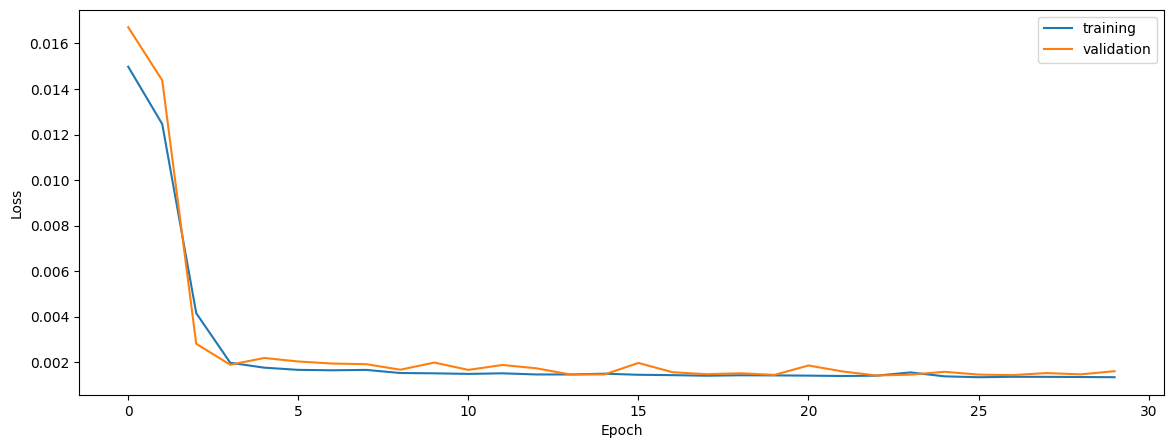

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


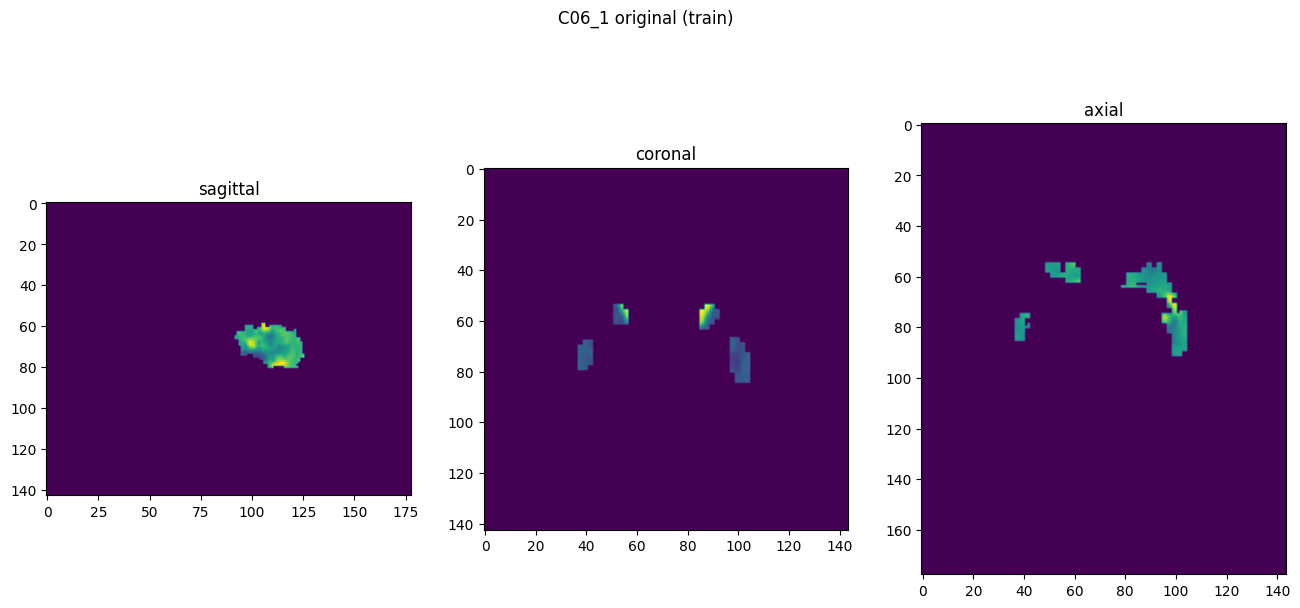

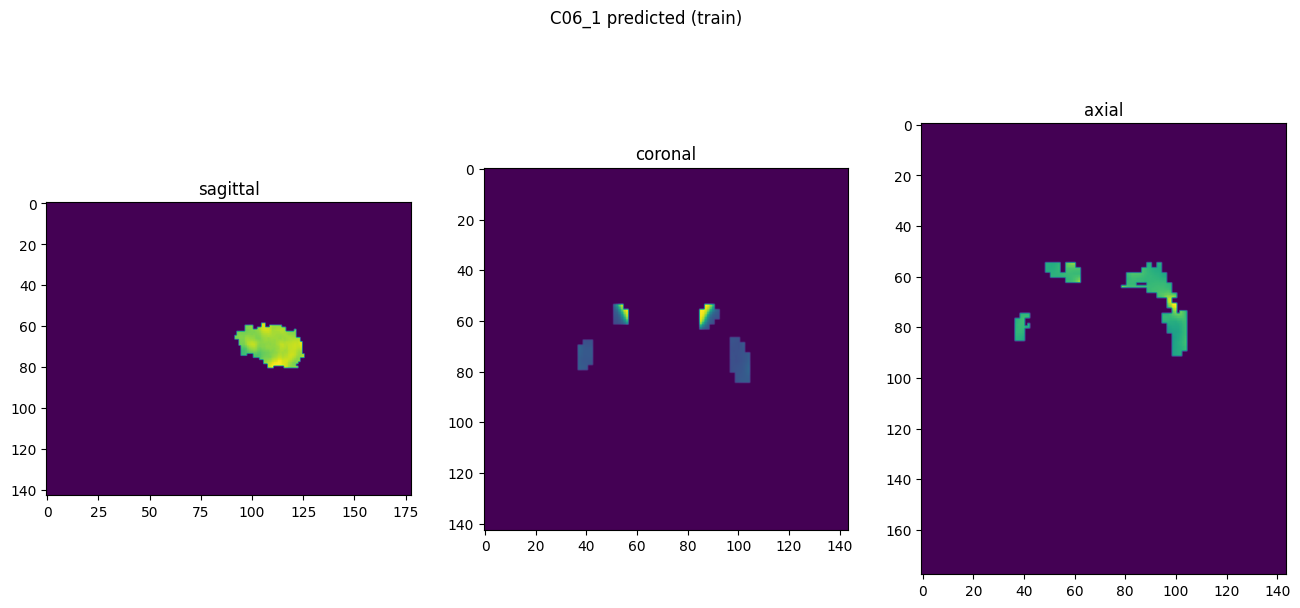

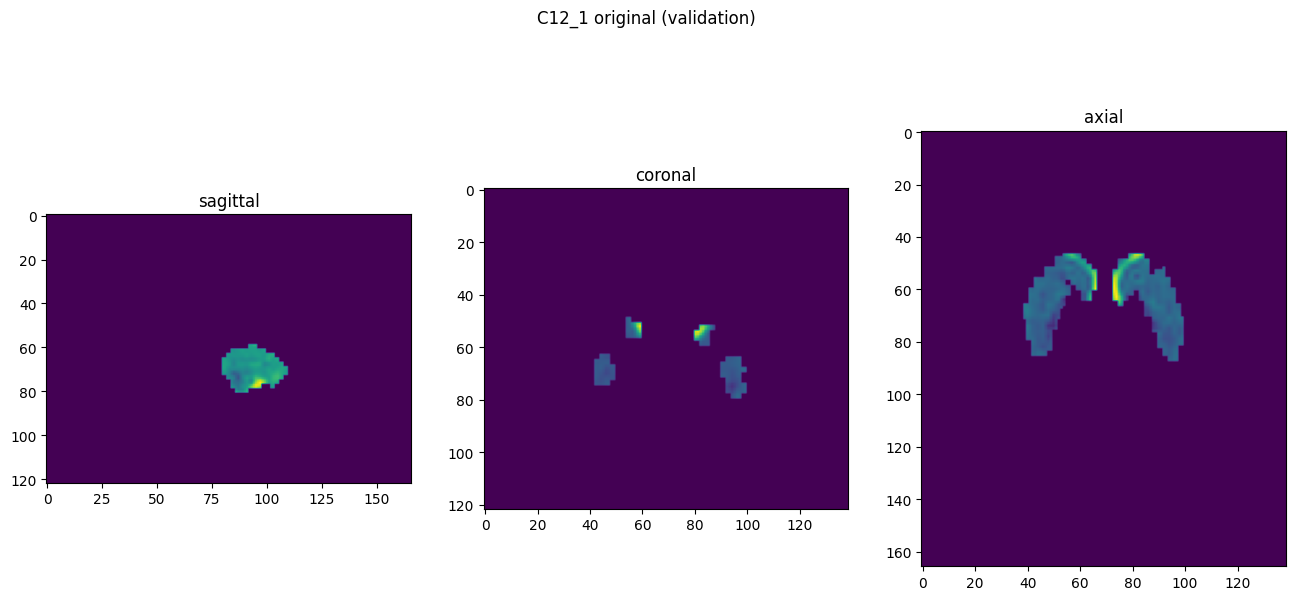

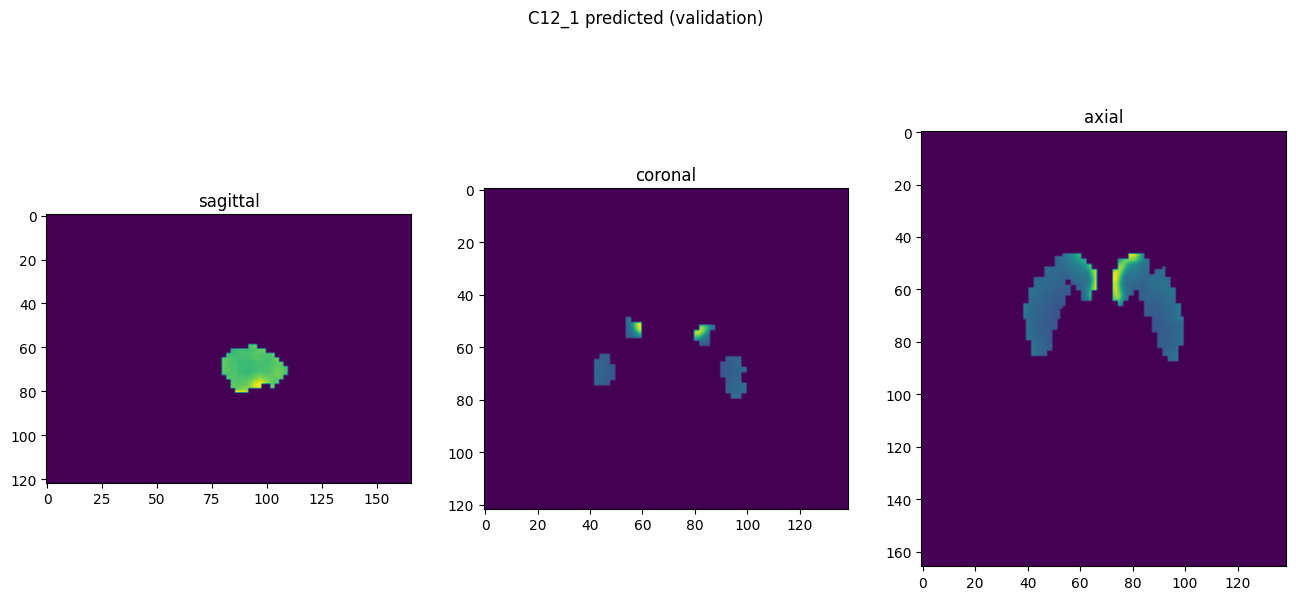

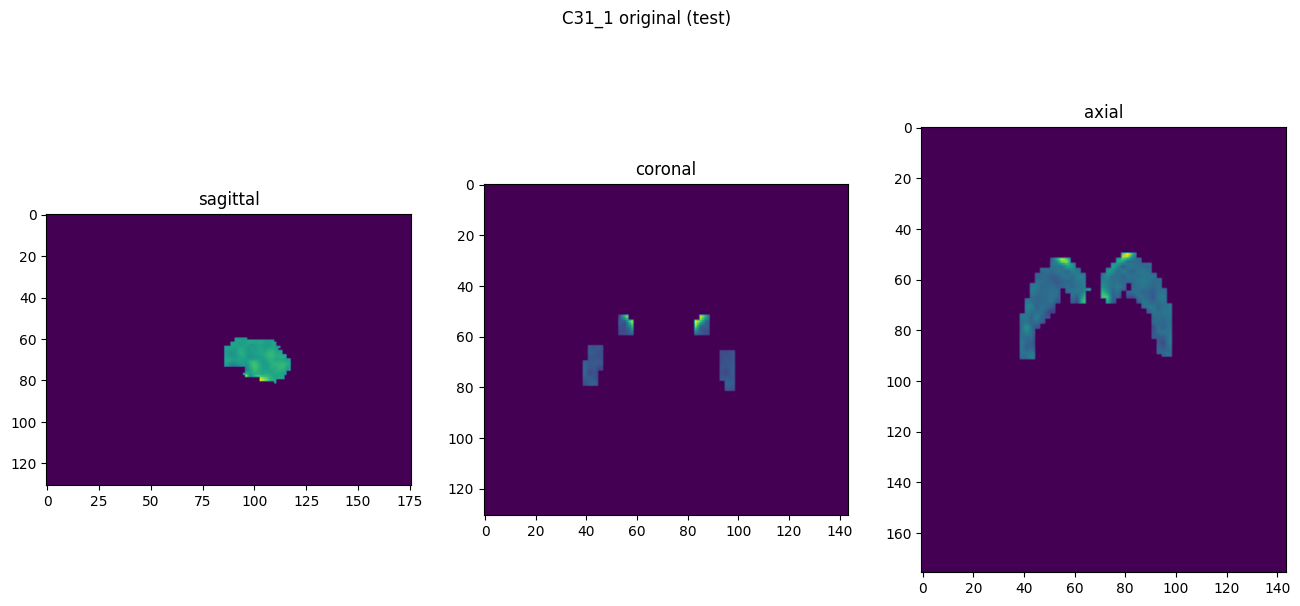

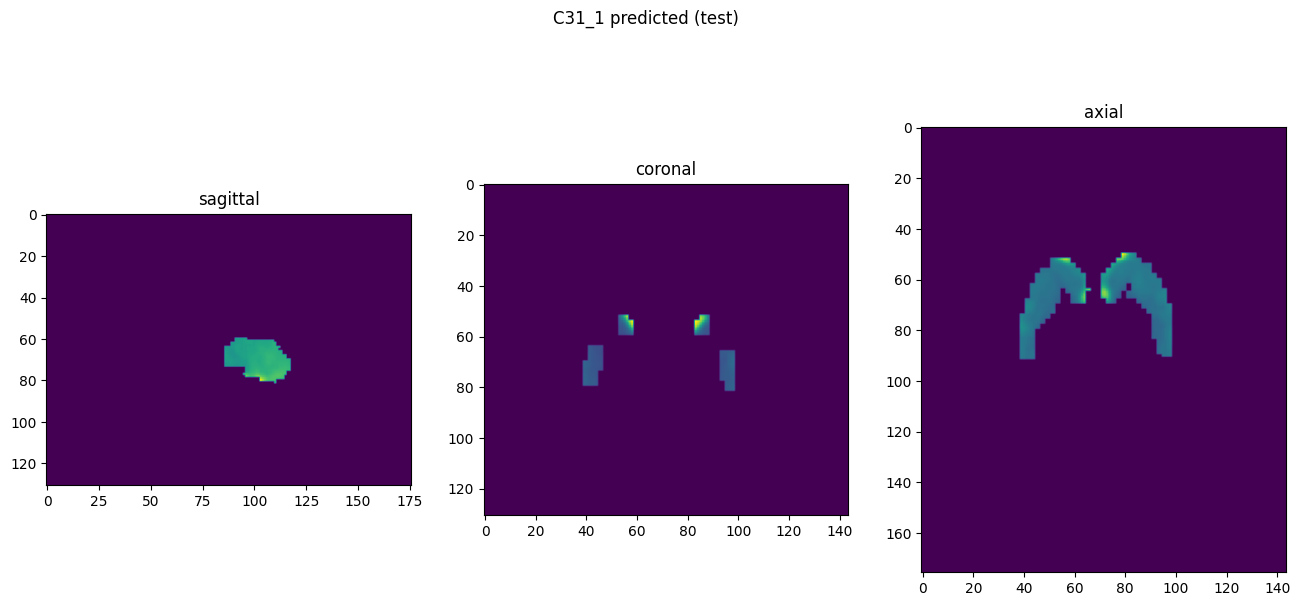

In [10]:
showResults(model, gen, threshold=None, background=False)